In [ ]:
!nvidia-smi

Tue Dec  3 03:29:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

100%|██████████| 398M/398M [00:02<00:00, 168MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

################################################################################

import xml.etree.cElementTree as ET
import glob
import os
import json
import random
import shutil
import subprocess
from PIL import Image, ImageOps

In [ ]:
'''
Arguments:
- bbox: the coordinates of the top-left and bottom-right corners of the bounding box [xmin, ymin, xmax, ymax]
- w: width of the image
- h: height of the image

Function:
1. ensures that all the 3 arguments are positive integers
2. ensures that the coordinates of the bounding boxes are valid (xmax > xmin)
3. calculate then normalize the center of the bounding box and its dimensions

Returns:
- normalize center coordinates and dimensions of the bounding box
'''

def convert_from_xml(bbox, w, h):
    if not all(isinstance(x, int) and x >= 0 for x in bbox + [w, h]):
        raise ValueError("All bounding box coordinates and dimensions must be non-negative integers.")

    if bbox[2] < bbox[0] or bbox[3] < bbox[1]:
        raise ValueError("xmax should be greater than xmin and ymax should be greater than ymin.")

    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h

    return [x_center, y_center, width, height]

In [ ]:
'''
Arguments:
- bbox: the coordinates of the top-left and bottom-right corners of the bounding box [xmin, ymin, xmax, ymax]
- w: width of the image
- h: height of the image

Function:
1. ensures that all the bounding box elements are normalized values (in the range [0, 1])
2. ensures w & h are positive integers
3. calculate and denormalize the half of the width and length of the bounding box
3. calculate the coordinates of the bounding box relative to the original image

Returns:
- normalize center coordinates and dimensions of the bounding box
'''

def convert_to_xml(bbox, w, h):
    if not (0 <= bbox[0] <= 1 and 0 <= bbox[1] <= 1 and 0 <= bbox[2] <= 1 and 0 <= bbox[3] <= 1):
        raise ValueError("YOLO coordinates must be in the range [0, 1].")

    if not isinstance(w, int) and isinstance(h, int) and w > 0 and h > 0:
        raise ValueError("Image dimensions must be positive integers.")

    half_width = bbox[2] * w / 2
    half_length = bbox[3] * h / 2

    xmin = int((bbox[0] * w) - half_width)
    ymin = int((bbox[1] * h) - half_length)
    xmax = int((bbox[0] * w) + half_width)
    ymax = int((bbox[1] * h) + half_length)

    return [xmin, ymin, xmax, ymax]

In [ ]:
# setup important paths

annotation_dir = "/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/annotations"
label_dir = "/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/labels"
image_dir = "/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images"

In [ ]:
# check if the labels directory exist and create it if not
if not os.path.exists(label_dir):
    os.mkdir(label_dir)

# list to store unique labels
classes = []

files = glob.glob(os.path.join(annotation_dir, "*.xml"))
for file in files:
    # extract file names without the extensions from annotation directory, and check for an image with the same name in the image directory
    basename = os.path.basename(file)
    filename = os.path.splitext(basename)[0]
    if not os.path.exists(os.path.join(image_dir, f"{filename}.png")):
        print(f"Image file {filename}.png does not exist.")
        continue

    # parse the .xml file that correspond to each image and extract the height and width
    tree = ET.parse(file)
    root = tree.getroot()
    width = int(root.find("size/width").text)
    height = int(root.find("size/height").text)

    # append unique labels to the classes list
    result = []
    for obj in root.findall("object"):
        label = obj.find("name").text
        if label not in classes:
            classes.append(label)

        # normalize bounding box coordinate from the .xml file
        index = classes.index(label)
        xml_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = convert_from_xml(xml_bbox, width, height)

        # store the class ID with the normalized coordinates in (result) list
        bbox_string = " ".join(map(str, yolo_bbox))
        result.append(f"{index} {bbox_string}")

    # write the result list to a .txt file in the labels directory with the same name as the corresponding image
    if result:
        with open(os.path.join(label_dir, f"{filename}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))

# saves the classes list (classes.txt) in the labels directory.
with open(os.path.join(label_dir, "classes.txt"), "w", encoding="utf-8") as f:
    f.write(json.dumps(classes, indent=4))

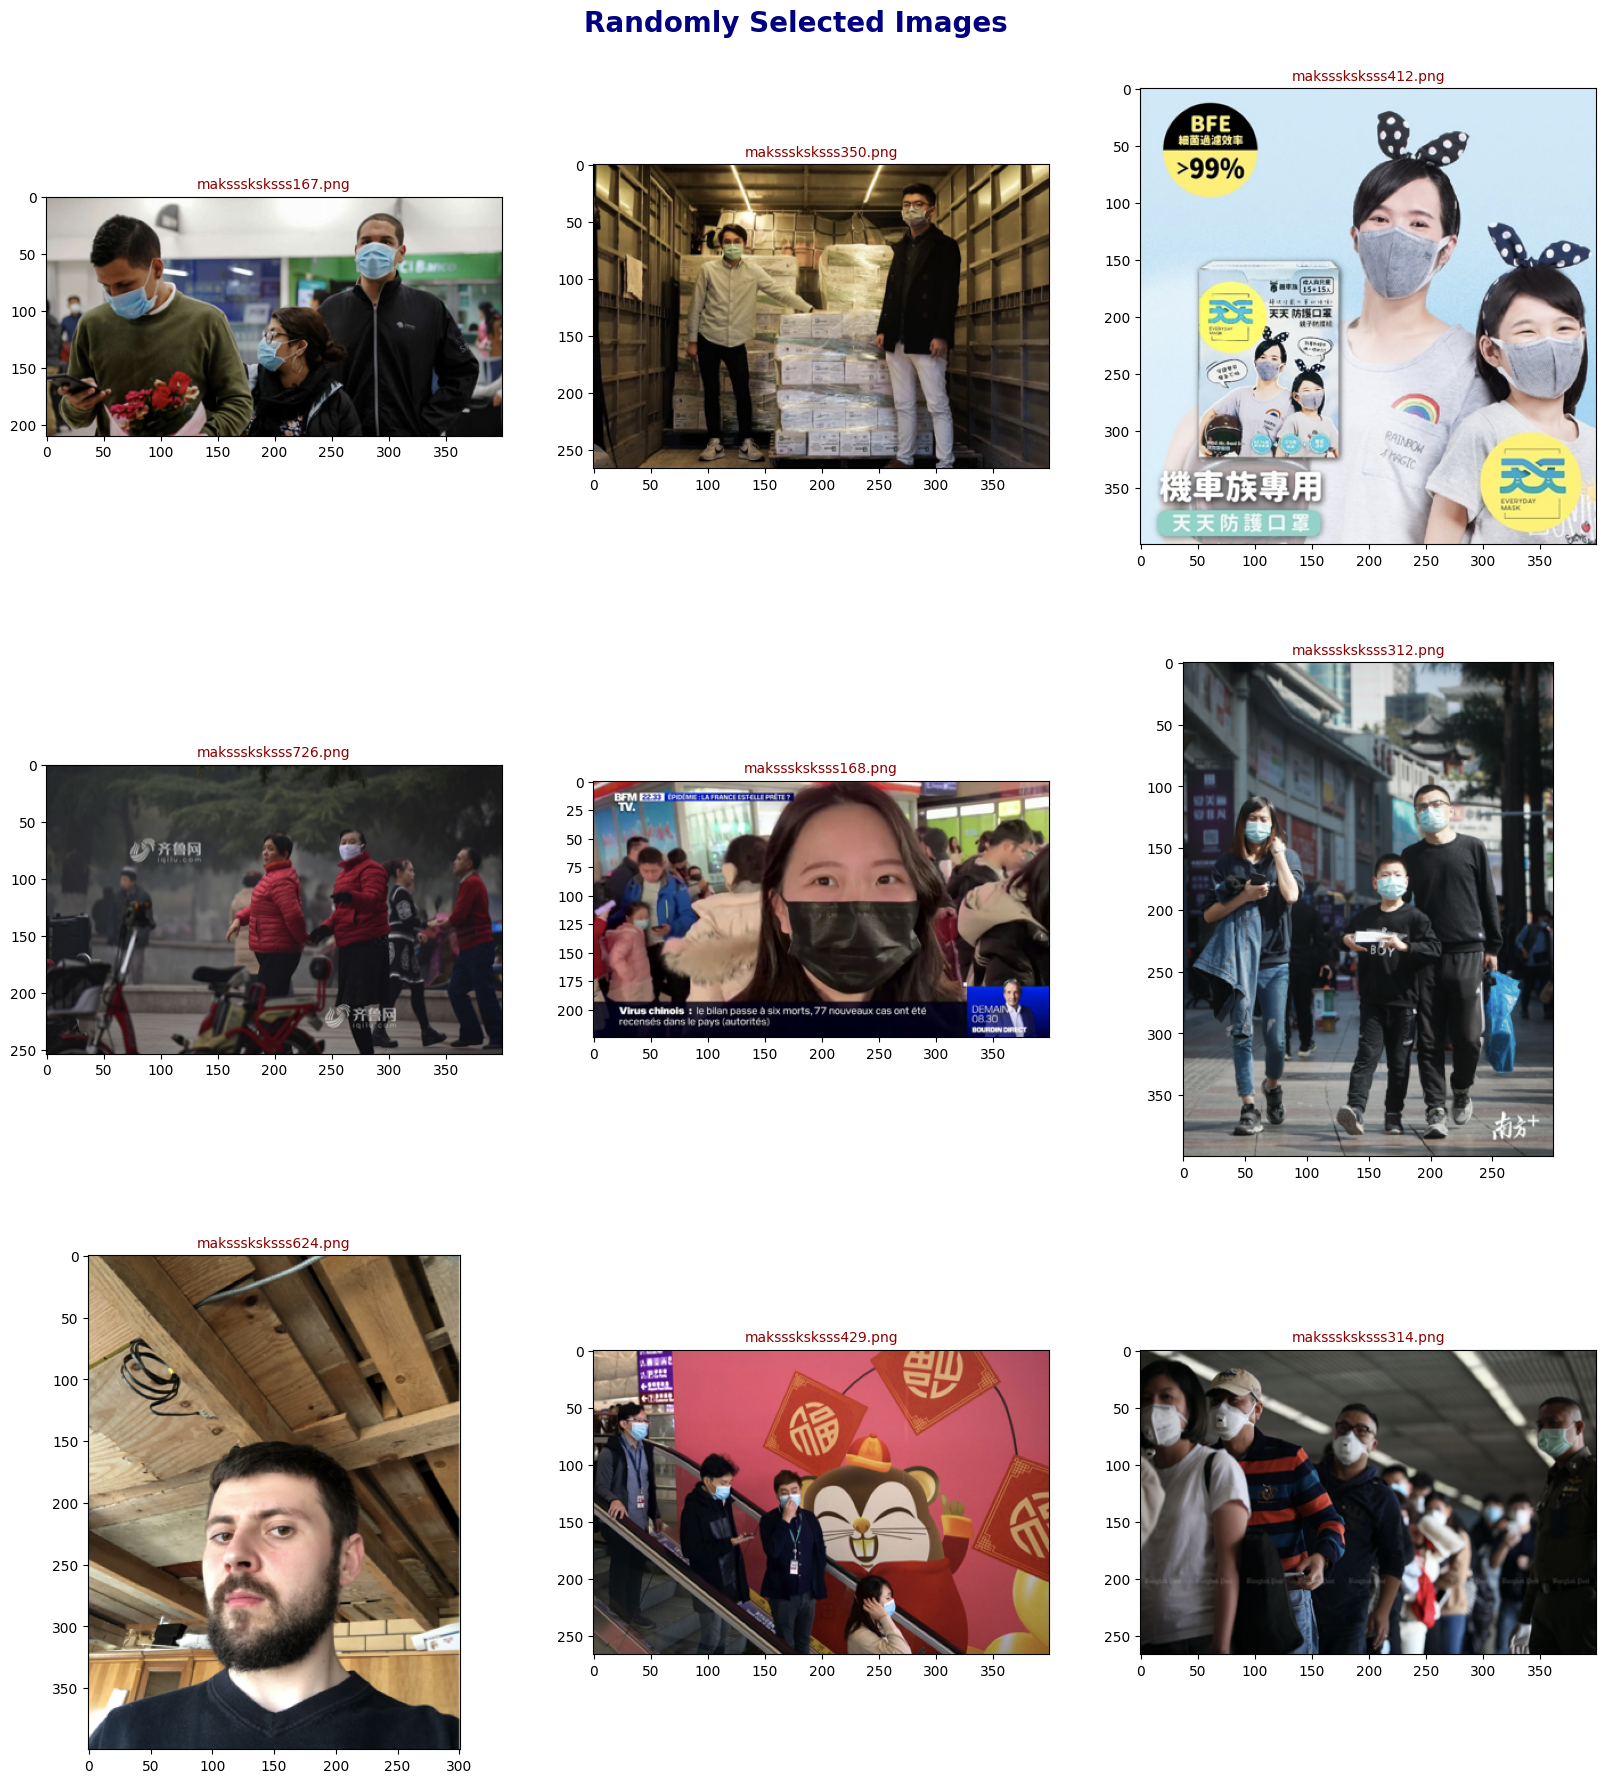

In [ ]:
images = os.listdir(image_dir)

if len(images) < 9:
    print("Not enough images to sample from.")
else:
    fig, axs = plt.subplots(3, 3, figsize=(20, 20))

    fig.suptitle('Randomly Selected Images', fontsize=20, fontweight='bold', color='navy')

    for i in range(3):
        random_images = random.sample(images, 3)
        for j, img_name in enumerate(random_images):
          img_path = os.path.join(image_dir, img_name)
          try:
              img = Image.open(img_path)
              axs[i][j].imshow(img)
              axs[i][j].set_title(img_name, fontsize=10, color='darkred')
              # axs[i][j].axis('off')
          except IOError:
              print(f"Failed to load image {img_name}")

    plt.subplots_adjust(top=0.95)

    plt.show()

In [ ]:
classes_file_path = os.path.join(label_dir, "classes.txt")

try:
    with open(classes_file_path, 'r') as f:
        contents = f.read()
        print("Classes loaded:")
        print(contents)
except FileNotFoundError:
    print(f"Error: The file '{classes_file_path}' does not exist.")

Classes loaded:
[
    "with_mask",
    "without_mask",
    "mask_weared_incorrect"
]


In [ ]:
try:
    annotation_count = len(os.listdir(annotation_dir))
    print(f"number of annotations is: ", annotation_count)
except FileNotFoundError:
    print(f"Error: The directory '{annotation_dir}' does not exist, or it is empty")
    annotation_count = 0  # Setting count to 0 as the directory does not exist

number of annotations is:  853


In [ ]:
try:
    images_count = len(os.listdir(image_dir))
    print(f"number of images is: ", images_count)
except FileNotFoundError:
    print(f"Error: The directory '{image_dir}' does not exist, or it is empty")
    images_count = 0  # Setting count to 0 as the directory does not exist

number of images is:  853


In [ ]:
try:
  labels_count = len(os.listdir(label_dir))
  # -1 to skip counting the classes.txt file with the labels
  print(f"number of labels: ", int(len(os.listdir(label_dir))-1))
except:
  print(f"Error: the directory {label_dir} doesn't exist, or it is empty")
  labels_count = 0  # Setting count to 0 as the directory does not exist

number of labels:  853


In [ ]:
data_partition_dir = '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/data partitions'

if not os.path.exists(data_partition_dir):
    os.mkdir(data_partition_dir)
    dataset_parts = ['train', 'validate', 'test']

    for part in dataset_parts:
        part_dir = os.path.join(data_partition_dir, part)
        os.mkdir(part_dir)

        os.mkdir(os.path.join(part_dir, 'images'))
        os.mkdir(os.path.join(part_dir, 'labels'))
else:
    print(f"The directory '{data_partition_dir}' already exists.")

print("Directory structure for training, validation, and testing has been created.")

Directory structure for training, validation, and testing has been created.


In [ ]:
x = len(os.listdir(label_dir))
print(x)
print(type(x))

854
<class 'int'>


In [ ]:
if 853 in {annotation_count, labels_count, images_count}:
  data_size = images_count
  training_size = round(data_size * 0.7)
  testing_size = round(data_size * 0.2)
  validation_size = round(data_size * 0.1)
  print(f"total size of data is: ", data_size)
  print(f"training size is: ", training_size)
  print(f"testing size is: ", testing_size)
  print(f"validation size is: ", validation_size)
else:
  print("Error: directories sizes (label, image, and annotation is not the same)")



total size of data is:  853
training size is:  597
testing size is:  171
validation size is:  85


0. base_dir:
"/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1"
1. annotation_dir:
 "/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/annotations"
2. label_dir:
 "/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/labels"
3. image_dir:
 "/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images"
4. data_partition_dir:
  '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/data partitions'


In [ ]:
file_names = [os.path.splitext(file)[0] for file in os.listdir(image_dir) if file.endswith('.png')]
# print(f"number of files: ", len(file_names))

def partition_data(names, label_folder, image_folder, data_partition_folder, type, size):
    for i in size:
      source_label = os.path.join(label_folder, names[i]+".txt")
      source_image = os.path.join(image_folder, names[i]+".png")

      dest_label_dir = os.path.join(data_partition_folder, str(type), 'labels')
      dest_image_dir = os.path.join(data_partition_folder, str(type), 'images')

      dest_label = os.path.join(dest_label_dir, names[i]+".txt")
      dest_image = os.path.join(dest_image_dir, names[i]+".png")

      shutil.copy(source_label, dest_label)
      shutil.copy(source_image, dest_image)
    print(f"number of labels copied to {type} labels is: ", len(os.listdir(dest_label_dir)))
    print(f"number of images copied to {type} images is: ", len(os.listdir(dest_image_dir)))

partition_data(file_names, label_dir, image_dir, data_partition_dir, 'train', range(0, training_size))
partition_data(file_names, label_dir, image_dir, data_partition_dir, 'test', range(training_size, training_size + testing_size))
partition_data(file_names, label_dir, image_dir, data_partition_dir, 'validate', range(training_size + testing_size, data_size))

number of labels copied to train labels is:  597
number of images copied to train images is:  597
number of labels copied to test labels is:  171
number of images copied to test images is:  171
number of labels copied to validate labels is:  85
number of images copied to validate images is:  85


In [ ]:
# YAML content for YOLOv9 training configuration
yaml_text = """
train: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/data partitions/train/images/
val: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/data partitions/validate/images

nc: 3
names: ["with_mask", "mask_weared_incorrect", "without_mask"]
"""

# Write the YAML configuration to a file
yaml_file_path = "/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/data partitions/data.yaml"
with open(yaml_file_path, 'w') as file:
    file.write(yaml_text)

# Read back and print the YAML file to verify its contents
with open(yaml_file_path) as f:
    contents = f.read()
    print(contents)


train: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/data partitions/train/images/
val: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/data partitions/validate/images

nc: 3
names: ["with_mask", "mask_weared_incorrect", "without_mask"]



In [ ]:
repo_url = "https://github.com/SkalskiP/yolov9.git"
clone_directory = "/root/.cache/kagglehub/YOLOv9"

if not os.path.exists(clone_directory):
    print("Cloning the YOLOv9 repository...")
    subprocess.run(["git", "clone", repo_url, clone_directory], check=True)
else:
    print("Repository already cloned.")

requirements_path = os.path.join(clone_directory, "requirements.txt")

if os.path.isfile(requirements_path):
    print("Installing dependencies from requirements.txt...")
    subprocess.run(["pip", "install", "-r", requirements_path, "-q"], check=True)
else:
    print(f"Failed to locate {requirements_path}. Ensure it is available before proceeding.")

Cloning the YOLOv9 repository...
Installing dependencies from requirements.txt...


In [ ]:
"""
Usage of YOLOv9 Training Command:
- workers: Number of worker threads for loading data. Adjust based on your CPU and memory availability.
- device: Specifies the GPU IDs, e.g., '0,1,2,3' for multi-GPU training, or 'cpu' for CPU training.
- batch: Batch size across all devices. '-1' for autobatch which adjusts based on GPU memory.
- epochs: Total number of training epochs.
- data: Path to the YAML file containing dataset paths and class info.
- img: Resolution size for training and validation images.
- cfg: Path to the model configuration YAML, defining layers and other model parameters.
- weights: Path to initial weights file for starting the training. An empty string '' means starting from scratch.
- name: Subdirectory within the project directory for saving training outputs.
- hyp: Path to hyperparameters YAML, affecting training dynamics like learning rate and augmentation settings.

**Adjust these parameters according to the specifics of your project.**
"""

# Training command for YOLOv9 using subprocess to make it usable within Python scripts
# Define the command as a list of elements
command = [
    "python", "/root/.cache/kagglehub/YOLOv9/train_dual.py",
    "--workers", "8",
    "--device", "0",
    "--batch", "8",
    "--epochs", "50",
    "--min-items", "0",
    "--close-mosaic", "15",
    "--data", "/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/data partitions/data.yaml",
    "--img", "640",
    "--cfg", "/root/.cache/kagglehub/YOLOv9/models/detect/yolov9.yaml",
    "--weights", "",
    "--name", "yolov9",
    "--hyp", "/root/.cache/kagglehub/YOLOv9/data/hyps/hyp.scratch-high.yaml"
]

# # Execute the command
# subprocess.run(command, check=True)


In [ ]:
try:
    result = subprocess.run(command, check=True, capture_output=True, text=True)
    print("Training output:", result.stdout)
except subprocess.CalledProcessError as e:
    print("Training error:", e.stderr)
    print("Return code:", e.returncode)

Training output: 


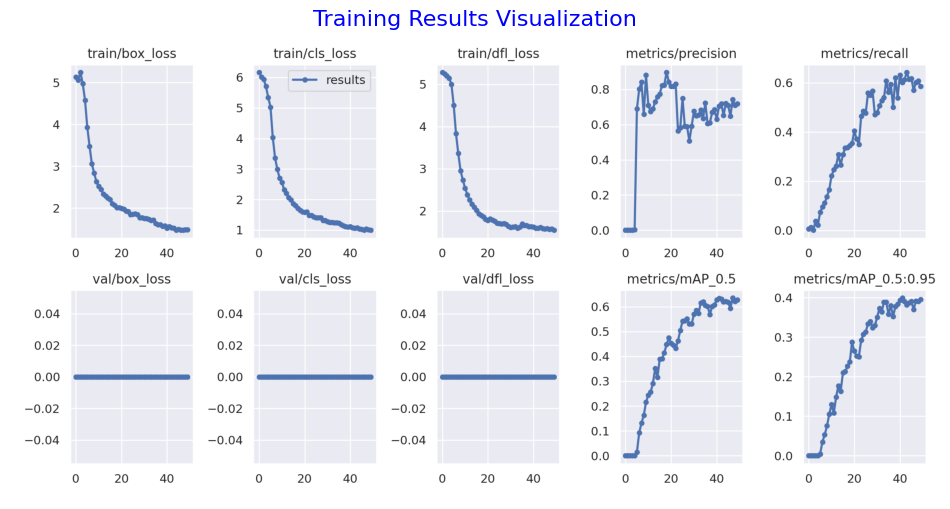

In [ ]:
# Define the path to the image
image_path = "/root/.cache/kagglehub/YOLOv9/runs/train/yolov94/results.png"

# Open the image file
img = Image.open(image_path)

# Display the image using Matplotlib
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed for better visibility
plt.imshow(img)
plt.axis('off')  # Turn off the axis numbers and ticks
plt.title("Training Results Visualization", fontsize=16, color='blue')  # Add a title with customization
plt.show()

In [ ]:
"""
Usage of YOLOv9 Inference Command:
- weights: Path to the model weights file, typically the best performing checkpoint.
- conf: Confidence threshold to filter predictions. Lower values increase the number of detections but may reduce precision.
- source: Path to the source of data for inference. This can be a directory of images, a single image, a video file, or a webcam.
- device: Specifies the CUDA device(s) IDs for GPU or 'cpu' to run on CPU.

**Adjust these parameters to match the specifics of your project and hardware configuration.**
"""

# Command to run inference using subprocess for better integration in Python scripts
# Define the command as a list of elements
command = [
    "python", "/root/.cache/kagglehub/YOLOv9/detect.py",
    "--weights", "/root/.cache/kagglehub/YOLOv9/runs/train/yolov94/weights/best.pt",
    "--conf", "0.5",
    "--source", "/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/data partitions/test/images",
    "--device", "0"
]

# Execute the command
subprocess.run(command, check=True)

CompletedProcess(args=['python', '/root/.cache/kagglehub/YOLOv9/detect.py', '--weights', '/root/.cache/kagglehub/YOLOv9/runs/train/yolov94/weights/best.pt', '--conf', '0.5', '--source', '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/data partitions/test/images', '--device', '0'], returncode=0)

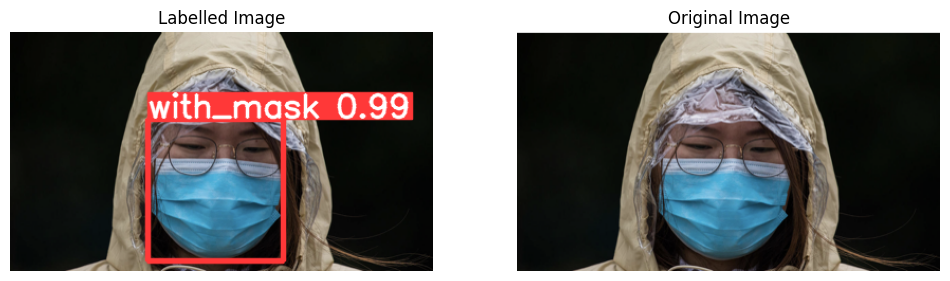

Result img file path: /root/.cache/kagglehub/YOLOv9/runs/detect/exp/maksssksksss63.png
Original img file path: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksksss63.png


In [ ]:
# Result of inference directory
detect_dir = '/root/.cache/kagglehub/YOLOv9/runs/detect/exp/'

# Original image directory prefix
orimg_prefix = '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/'

# Get all files in the result directory
image_files = [f for f in os.listdir(detect_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Ensure there are images before proceeding
if not image_files:
    print("No image files found in the directory.")
else:
    # Randomly pick one image file
    selected_file = random.choice(image_files)

    # Load the result image
    res_image = Image.open(os.path.join(detect_dir, selected_file))

    # Construct original img file path assuming the filenames match between directories
    ori_file_path = os.path.join(orimg_prefix, selected_file)

    # Try to load the original image from the path
    try:
        ori_image = Image.open(ori_file_path)
        original_exists = True
    except FileNotFoundError:
        print(f"Original image not found at {ori_file_path}")
        original_exists = False

    # Display the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(res_image)
    axes[0].axis('off')
    axes[0].set_title('Labelled Image')

    if original_exists:
        axes[1].imshow(ori_image)
        axes[1].axis('off')
        axes[1].set_title('Original Image')
    else:
        axes[1].text(0.5, 0.5, 'Original image not available', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)
        axes[1].axis('off')

    plt.show()

    print("Result img file path:", os.path.join(detect_dir, selected_file))
    print("Original img file path:", ori_file_path)

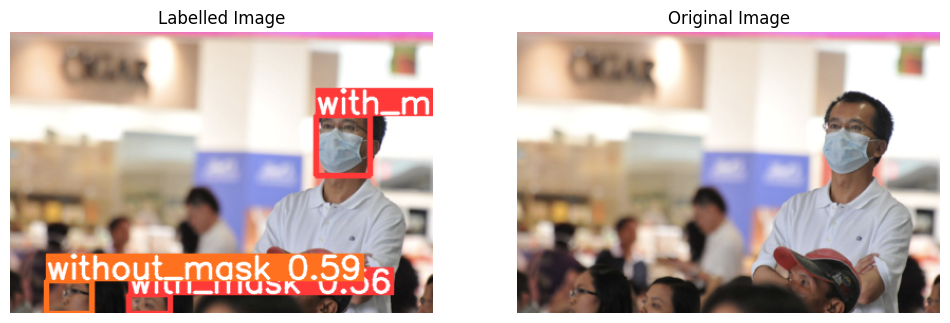

Result img file path: /root/.cache/kagglehub/YOLOv9/runs/detect/exp/maksssksksss279.png
Original img file path: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksksss279.png


In [ ]:
# Result of inference directory
detect_dir = '/root/.cache/kagglehub/YOLOv9/runs/detect/exp/'

# Original image directory prefix
orimg_prefix = '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/'

# Get all files in the result directory
image_files = [f for f in os.listdir(detect_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Ensure there are images before proceeding
if not image_files:
    print("No image files found in the directory.")
else:
    # Randomly pick one image file
    selected_file = random.choice(image_files)

    # Load the result image
    res_image = Image.open(os.path.join(detect_dir, selected_file))

    # Construct original img file path assuming the filenames match between directories
    ori_file_path = os.path.join(orimg_prefix, selected_file)

    # Try to load the original image from the path
    try:
        ori_image = Image.open(ori_file_path)
        original_exists = True
    except FileNotFoundError:
        print(f"Original image not found at {ori_file_path}")
        original_exists = False

    # Display the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(res_image)
    axes[0].axis('off')
    axes[0].set_title('Labelled Image')

    if original_exists:
        axes[1].imshow(ori_image)
        axes[1].axis('off')
        axes[1].set_title('Original Image')
    else:
        axes[1].text(0.5, 0.5, 'Original image not available', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)
        axes[1].axis('off')

    plt.show()

    print("Result img file path:", os.path.join(detect_dir, selected_file))
    print("Original img file path:", ori_file_path)

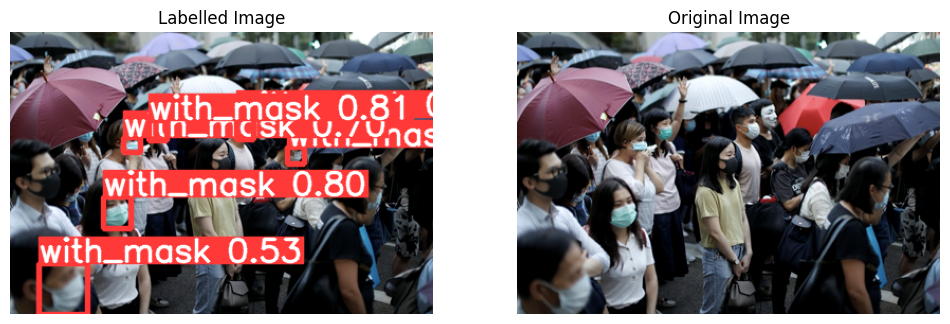

Result img file path: /root/.cache/kagglehub/YOLOv9/runs/detect/exp/maksssksksss676.png
Original img file path: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/maksssksksss676.png


In [ ]:
# Result of inference directory
detect_dir = '/root/.cache/kagglehub/YOLOv9/runs/detect/exp/'

# Original image directory prefix
orimg_prefix = '/root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images/'

# Get all files in the result directory
image_files = [f for f in os.listdir(detect_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Ensure there are images before proceeding
if not image_files:
    print("No image files found in the directory.")
else:
    # Randomly pick one image file
    selected_file = random.choice(image_files)

    # Load the result image
    res_image = Image.open(os.path.join(detect_dir, selected_file))

    # Construct original img file path assuming the filenames match between directories
    ori_file_path = os.path.join(orimg_prefix, selected_file)

    # Try to load the original image from the path
    try:
        ori_image = Image.open(ori_file_path)
        original_exists = True
    except FileNotFoundError:
        print(f"Original image not found at {ori_file_path}")
        original_exists = False

    # Display the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(res_image)
    axes[0].axis('off')
    axes[0].set_title('Labelled Image')

    if original_exists:
        axes[1].imshow(ori_image)
        axes[1].axis('off')
        axes[1].set_title('Original Image')
    else:
        axes[1].text(0.5, 0.5, 'Original image not available', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)
        axes[1].axis('off')

    plt.show()

    print("Result img file path:", os.path.join(detect_dir, selected_file))
    print("Original img file path:", ori_file_path)

In [ ]:
from google.colab import files
files.download('/root/.cache/kagglehub/YOLOv9')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>